In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
import scipy as sp
from scipy.signal import convolve2d
from scipy.ndimage import rotate
from skimage.draw import circle


# Custom modules
from lib import myhelpers as hlp
from lib.envmap import Map, Rect

In [2]:
grid_res  = 2 # 2x2 grid resolution
angle_res = np.radians(5) # 5 degree angle resolution

robot_dims = np.array([50,50]) # robot is 50 x 50 square
clearance = 50/2    # recontextualizing the robot as a point at the center of the bot,
                    # it requires <clearance> units of clearance between it and an obstacle

# Map dimensions
xlim = (0,800)
ylim = (0,300)

map_width  = np.diff(xlim)
map_height = np.diff(ylim)

# Define map
env = Map(origin=(0,0), xlim=xlim, ylim=ylim, resolution=grid_res, lefthanded=True) # arraylike indiates dimensions are left-handed

obstacles = [
    # Outer borders - start and endpoints
    [(0,0),(800,0)],
    [(0,0),(0,300)],
    [(800,0),(800,300)],
    [(0,300),(800,300)],
    # Inner borders
    [(200,0),(200,200)],
    [(100,200),(300,200)],
    [(400,300),(400,100)],
    [(600,0),(600,200)],
    [(500,200),(700,200)]
]

[env.draw_line(*o) for o in obstacles];

# # Inflate borders by clearance to 
# inflated_borders = [
#     # Top boundary -- inflated by clearance
#     Rect(width=map_width,  height=clearance, anchor=(0,0)) ,
#     Rect(width=-map_width,  height=-clearance, anchor=(map_width,map_height)) , # bottom
#     Rect(width=clearance, height=map_height, anchor=(0,0)) , # left
#     Rect(width=-clearance,  height=-map_height, anchor=(map_width,map_height))   # right
# ]
# [env.fill_rect(r) for r in inflated_borders];

In [3]:
env.grid

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 1],
       ...,
       [1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 1],
       [1, 1, 1, ..., 1, 1, 1]])

/home/aefrank/applications/anaconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  # Remove the CWD from sys.path while we load stuff.
/home/aefrank/applications/anaconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  app.launch_new_instance()
/home/aefrank/applications/anaconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


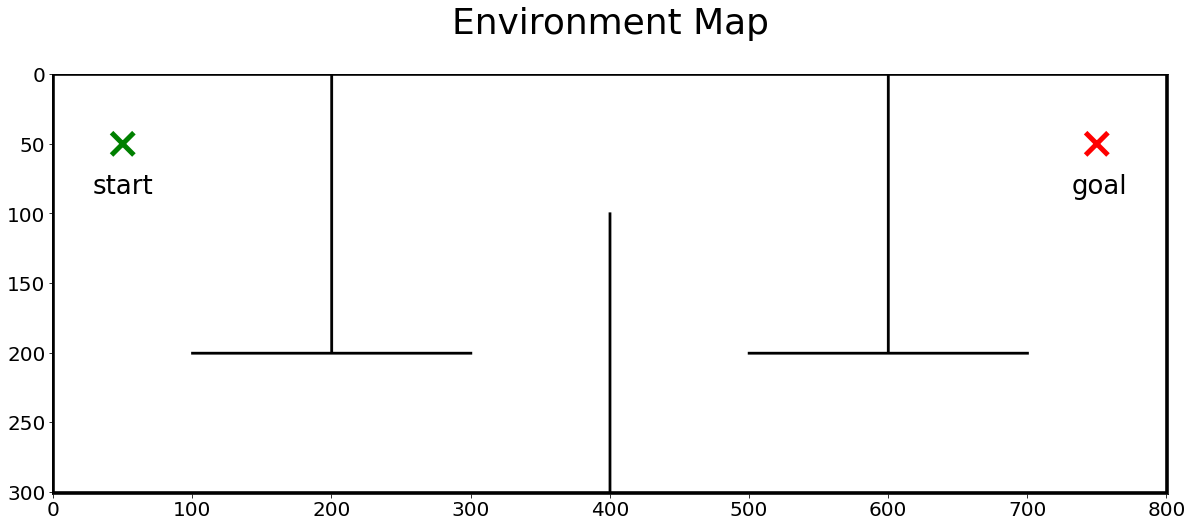

In [4]:
fig, ax = plt.subplots(figsize=(20,20), facecolor='white')

# Plot environment
scaled_grid = np.kron(env.grid, np.ones((2, 2), dtype=env.grid.dtype)) # Inflate so each grid square is 2x2 pixels
ax.imshow(scaled_grid, cmap='gray_r')
# Plot start and end points with x markers
start = np.array([50,50])
end = np.array([750,50])
plt.scatter(x=[start[0],end[0]], y=[start[1],end[1]], 
            marker='x', c='gr', s=500, linewidth=5)

# Formatting
plt.title('Environment Map', fontsize=36, pad=40)
ax.tick_params(axis='both', labelsize=20)
ax.annotate(xy=start, xytext=[-30,-50], textcoords='offset points',
             s='start', fontsize=26)
ax.annotate(xy=end, xytext=[-25,-50], textcoords='offset points',
             s='goal', fontsize=26);

Collision detection can be calculated with Minkowski difference. This can be calculated through convolving one polygon along the edges of the other. 

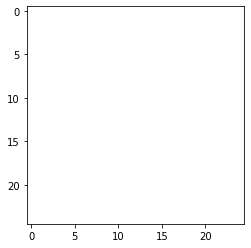

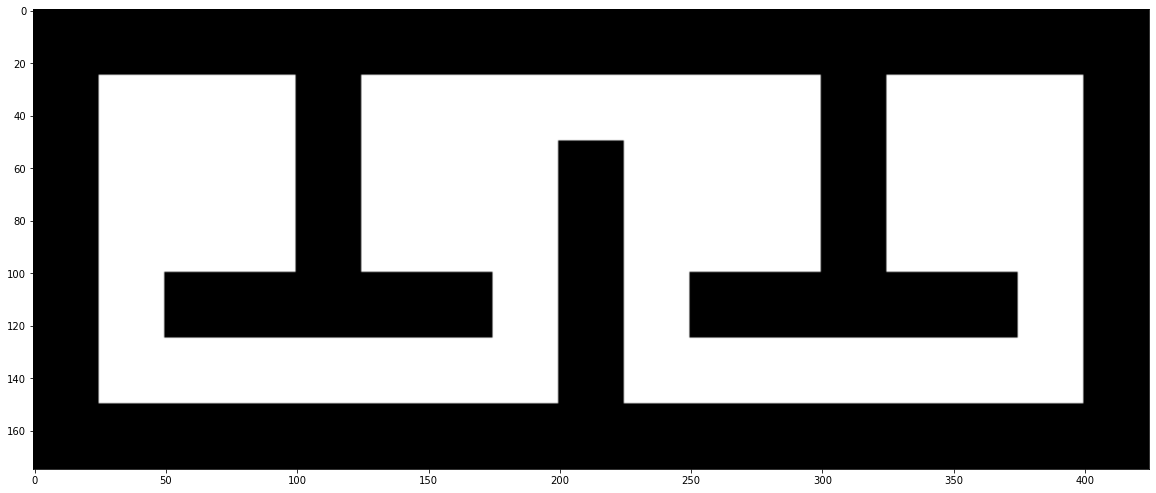

In [5]:
# Convolve the square robot itself with the environment to see where it can go without 
# colliding at a given orientation.

l = int(np.ceil(50/grid_res))
mask = np.ones((l,l))
plt.imshow(mask, cmap='gray_r') # colormap makes it look white because its all 1s but 
                 # trust me it's all filled in with 1s


output = convolve2d(env.grid,mask,fillvalue=1)
output[np.nonzero(output)] = 1

fig, ax = plt.subplots(figsize=(20,20))
plt.imshow(output, cmap='gray_r')

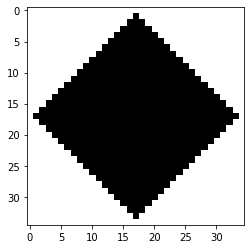

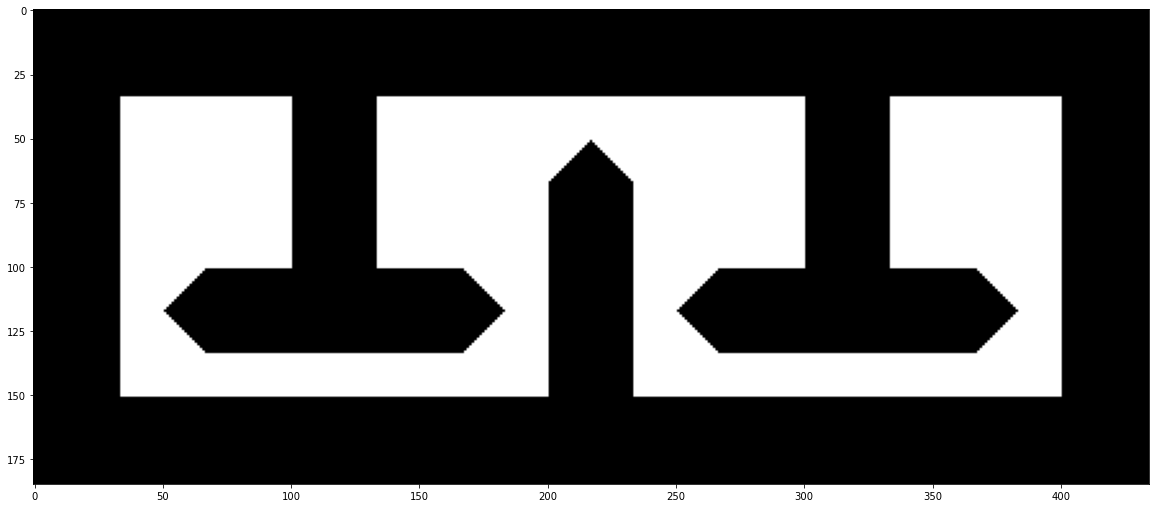

In [6]:
# Let's try at orientation 45 degrees
mask = rotate(mask,45,reshape=True)
plt.imshow(mask, cmap='gray_r')

output = convolve2d(env.grid,mask,fillvalue=1)
output[np.nonzero(output)] = 1

fig, ax = plt.subplots(figsize=(20,20))
plt.imshow(output, cmap='gray_r')

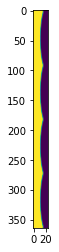

In [7]:
# Angular resolution "blur"
# Reference: http://chemaguerra.com/circular-radial-blur/
# Scikit image ref: https://scikit-image.org/docs/stable/auto_examples/registration/plot_register_rotation.html
from skimage.transform import warp_polar, rotate, rescale, warp
from skimage.util import img_as_float

radius = hlp.sqrt(2)*(mask.shape[0]/2) # make sure polar transform gets all the way to corner points

image = mask
image = img_as_float(image)
image_polar = warp_polar(image, radius=radius)
plt.imshow(image_polar)

blur = np.ones((5,1))/5

image_blurred = convolve2d(image_polar,blur,boundary='wrap')
plt.imshow(image_blurred)


In [8]:
warped = warp(image, warp_polar)

plt.imshow(warped)

ValueError: cannot reshape array of size 220680 into shape (35,35)

In [ ]:
# temperature = <whatever> 
# This is the data in your polar grid.
# The 0th and 1st axes correspond to r and θ, respectively.
# For the sake of simplicity, θ goes from 0 to 2π, 
# and r's units are just its indices.

def polar2cartesian(outcoords, inputshape, origin):
    """Coordinate transform for converting a polar array to Cartesian coordinates. 
    inputshape is a tuple containing the shape of the polar array. origin is a
    tuple containing the x and y indices of where the origin should be in the
    output array."""

    xindex, yindex = outcoords
    x0, y0 = origin
    x = xindex - x0
    y = yindex - y0

    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    theta_index = np.round((theta + N.pi) * inputshape[1] / (2 * N.pi))

    return (r,theta_index)

temperature_cartesian = S.ndimage.geometric_transform(temperature, polar2cartesian, 
    order=0,
    output_shape = (temperature.shape[0] * 2, temperature.shape[0] * 2),
    extra_keywords = {'inputshape':temperature.shape,
        'center':(temperature.shape[0], temperature.shape[0])})


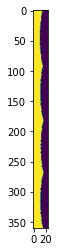

In [29]:
import cv2

source = image

#--- ensure image is of the type float ---
img = source.astype(np.float32)

#--- the following holds the square root of the sum of squares of the image dimensions ---
#--- this is done so that the entire width/height of the original image is used to express the complete circular range of the resulting polar image ---
value = radius #np.sqrt(((img.shape[0]/2.0)**2.0)+((img.shape[1]/2.0)**2.0))
center = np.array(img.shape)/2

polar_image = cv2.warpPolar(img, dsize=(int(radius),360), center=tuple(center), 
                            maxRadius=radius, flags=cv2.WARP_FILL_OUTLIERS)

# polar_image = cv2.linearPolar(img,(img.shape[0]/2, img.shape[1]/2), 
#                               value, cv2.WARP_FILL_OUTLIERS)

polar_image = polar_image.astype(np.uint8)
plt.imshow(polar_image)


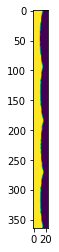

In [27]:
blur = np.ones((5,1))/5

image_blurred = convolve2d(polar_image,blur,boundary='wrap')
plt.imshow(image_blurred)

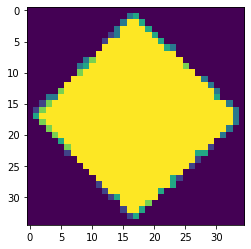

In [62]:
out = cv2.warpPolar(src=image_blurred, dsize=image.shape, center=tuple(center), 
          maxRadius=radius, flags=cv2.WARP_FILL_OUTLIERS + cv2.WARP_INVERSE_MAP)

plt.imshow(out)

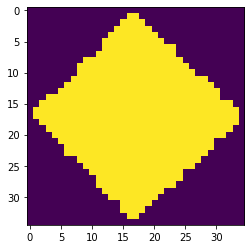

In [65]:
out[np.nonzero(out)]=1
plt.imshow(out)